## Importing Packages

In [131]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import precision_recall_curve, precision_score, recall_score

## Importing Datasets

In [8]:
billingRaw = pd.read_csv('../datasets/billing.csv')
eventsRaw = pd.read_csv('../datasets/events.csv')
sessionsRaw = pd.read_csv('../datasets/sessions.csv')
usersRaw = pd.read_csv('../datasets/users.csv')

## Plan tiers to numeric

In [10]:
billingRaw.loc[billingRaw['plan_tier'] == 'free', billingRaw.columns[2]] = 0
billingRaw.loc[billingRaw['plan_tier'] == 'standard', billingRaw.columns[2]] = 1
billingRaw.loc[billingRaw['plan_tier'] == 'premium', billingRaw.columns[2]] = 2
billingRaw['plan_tier'] = pd.to_numeric(billingRaw['plan_tier'], errors='coerce')

## Converting to datetime

In [12]:
billingRaw['month'] = pd.to_datetime(billingRaw['month'], format = '%Y-%m')
type(billingRaw['month'])

pandas.core.series.Series

## Condensed Feature Engineering
Full thought process on billingEDA.ipynb

In [14]:
upgrade_df = billingRaw.groupby('user_id')['plan_tier'].agg(['first', 'last']).reset_index()
upgrade_df['upgrade'] = (upgrade_df['last'] > upgrade_df['first']).astype(int)
upgrade_df.loc[upgrade_df['last'] < upgrade_df['first'], 'upgrade'] = -1
upgrade_df = upgrade_df.drop(['first', 'last'], axis = 1)
discount_df = billingRaw.groupby("user_id")["discount_applied"].max().reset_index().drop('user_id', axis = 1)
upgrade_df = pd.concat([upgrade_df, discount_df], axis = 1)
seats_df = billingRaw.groupby('user_id').tail(1)[['user_id', 'active_seats']].drop_duplicates('user_id')



upgrade_df = upgrade_df.merge(seats_df, on='user_id', how='left')
support_df = billingRaw.groupby('user_id').tail(1)[['user_id', 'support_ticket_count']].drop_duplicates('user_id')
upgrade_df = upgrade_df.merge(support_df, on='user_id', how='left')
billingRaw['plan_tier_shift'] = billingRaw.groupby('user_id')['plan_tier'].shift()
billingRaw['tier_change'] = billingRaw['plan_tier'] != billingRaw['plan_tier_shift']
first_rows_idx = billingRaw.groupby('user_id').head(1).index
billingRaw.loc[first_rows_idx, 'tier_change'] = False

first_change_prev_idx = (
    billingRaw[billingRaw['tier_change']]
      .groupby('user_id')
      .head(1)
      .index - 1
)

billingRaw['seats'] = np.nan
billingRaw.loc[first_change_prev_idx, 'seats'] = billingRaw.loc[first_change_prev_idx, 'active_seats']

no_change_mask = billingRaw.groupby('user_id')['tier_change'].transform('sum').eq(0)
last_rows_no_change = billingRaw[no_change_mask].groupby('user_id').tail(1)
billingRaw.loc[last_rows_no_change.index, 'seats'] = last_rows_no_change['active_seats']

seats_before = (
    billingRaw.dropna(subset=['seats'])
              .drop_duplicates('user_id')[['user_id', 'seats']]
              .reset_index(drop=True)
)

upgrade_df = upgrade_df.merge(seats_before, on='user_id', how='left')
upgrade_df = upgrade_df.drop('active_seats', axis = 1)
billingRaw['plan_tier_shift'] = billingRaw.groupby('user_id')['plan_tier'].shift()
billingRaw['tier_change'] = billingRaw['plan_tier'] != billingRaw['plan_tier_shift']
first_rows_idx = billingRaw.groupby('user_id').head(1).index
billingRaw.loc[first_rows_idx, 'tier_change'] = False

first_change_prev_idx = (
    billingRaw[billingRaw['tier_change']]
      .groupby('user_id')
      .head(1)
      .index - 1
)

billingRaw['support_tickets'] = np.nan
billingRaw.loc[first_change_prev_idx, 'support_tickets'] = billingRaw.loc[first_change_prev_idx, 'support_ticket_count']

no_change_mask = billingRaw.groupby('user_id')['tier_change'].transform('sum').eq(0)
last_rows_no_change = billingRaw[no_change_mask].groupby('user_id').tail(1)
billingRaw.loc[last_rows_no_change.index, 'support_tickets'] = last_rows_no_change['support_ticket_count']

support_tickets_before = (
    billingRaw.dropna(subset=['support_tickets'])
              .drop_duplicates('user_id')[['user_id', 'support_tickets']]
              .reset_index(drop=True)
)
upgrade_df = upgrade_df.merge(support_tickets_before, on='user_id', how='left')
upgrade_df = upgrade_df.drop('support_ticket_count', axis = 1)
activeUpgrades = upgrade_df[upgrade_df['upgrade'] != 0]

## Feature Engineering with events.csv
Note that this is condensed and doesn't show full thought process. Full process on billingEDA.ipynb

In [16]:
eventsRaw = eventsRaw.drop('event_id', axis = 1)
action_counts = eventsRaw.groupby('user_id')['action'].value_counts().unstack(fill_value=0).reset_index()
action_counts['total'] = action_counts[['click', 'complete', 'view']].sum(axis = 1)
df = activeUpgrades
df = df.merge(action_counts, on='user_id', how='left')
df = df.dropna()
df = df.drop(['click', 'complete', 'view'], axis = 1)
df['upgrade'] = df['upgrade'].replace(-1, 0)

## Finished dataset
### upgrade
0 is downgrade, 1 is upgrade

### discount_applied
0 if discount not applied, 1 if discount applied

### seats
number of seats BEFORE upgrading or downgrading

### support_tickets
support tickets the month BEFORE upgrading or downgrading

### total
total actions (click, view, complete)

In [18]:
df

,user_id,upgrade,discount_applied,seats,support_tickets,total
0,0031b10d-a3fb-4fa6-a27b-ea1ef8d5131b,0,0,8.0,0.0,4.0
3,00503b30-79b8-4aed-aeb5-a91aca3053be,0,0,117.0,2.0,2.0
5,007bb89e-1b35-4392-84c9-c4248197157b,1,1,13.0,1.0,1.0
6,0081cb57-7415-430e-a867-929319021a16,1,1,9.0,0.0,5.0
8,00cc5c06-3119-4761-b012-2d6e30054d9b,0,0,89.0,4.0,17.0
...,...,...,...,...,...,...
4822,ff5a14b2-b74b-4c55-ab12-302c6869664a,1,1,8.0,0.0,8.0
4823,ff5d04b7-12b0-4b05-967d-62322e6c83c1,1,1,22.0,1.0,1.0
4825,ff844a5d-2fea-4218-9a7c-aee980e53b2d,0,1,21.0,0.0,2.0
4826,ff8bbc6d-6b53-4cfb-89ce-d3eeed8fb238,1,1,1.0,0.0,3.0


## Fitting logistic regression model

In [20]:
x = df.iloc[:, 2:]
y = df.iloc[:, 1]

xtrain, xtest, ytrain, ytest = train_test_split(x, y, stratify=y, random_state = 0)
model = LogisticRegression(solver='lbfgs', max_iter=10000, class_weight='balanced')
model.fit(xtrain, ytrain)
ypred = model.predict(xtest)

print(classification_report(ytest, ypred))

xtrain = sm.add_constant(xtrain)
model = sm.Logit(ytrain, xtrain)
result = model.fit()

print(result.summary())

              precision    recall  f1-score   support

           0       0.70      0.57      0.63       454
           1       0.61      0.73      0.67       412

    accuracy                           0.65       866
   macro avg       0.66      0.65      0.65       866
weighted avg       0.66      0.65      0.65       866

Optimization terminated successfully.
         Current function value: 0.612027
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                upgrade   No. Observations:                 2595
Model:                          Logit   Df Residuals:                     2590
Method:                           MLE   Df Model:                            4
Date:                Mon, 15 Sep 2025   Pseudo R-squ.:                  0.1156
Time:                        12:01:00   Log-Likelihood:                -1588.2
converged:                       True   LL-Null:                       -1795.8
Covariance Type:  

## EDA graphs

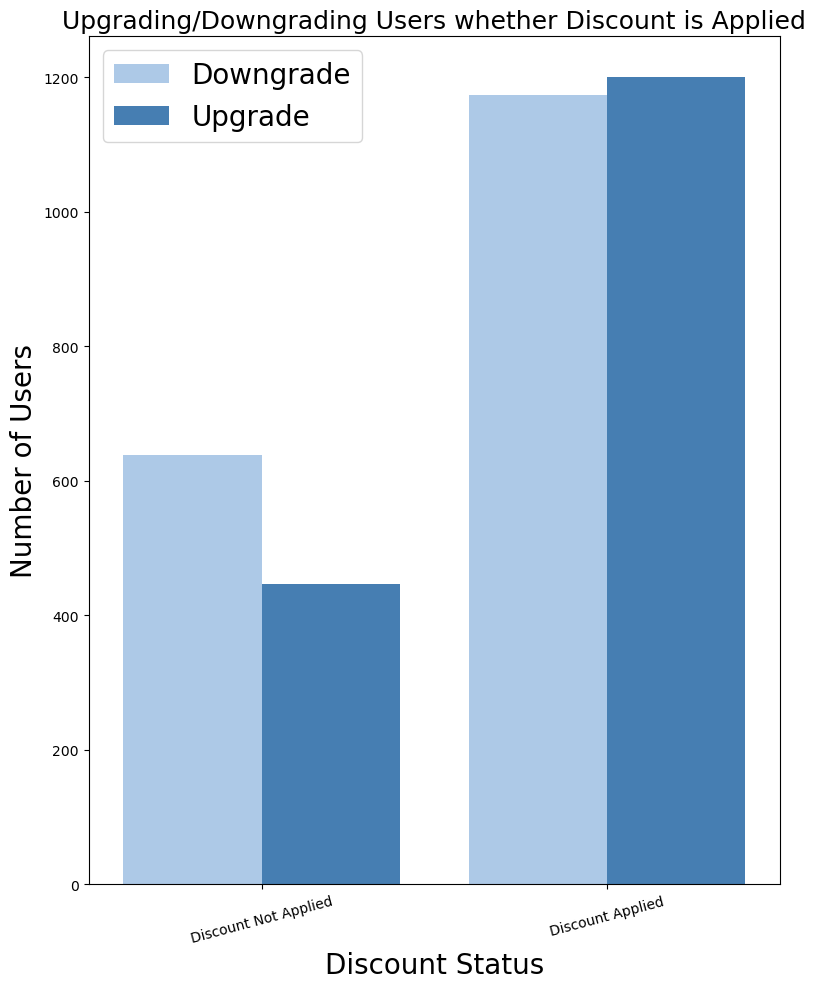

In [113]:
df_plot = df.copy()
df_plot['upgrade'] = df_plot['upgrade'].map({0: 'Downgrade', 1: 'Upgrade'})
df_plot['discount_applied'] = df_plot['discount_applied'].map({0: 'Discount Not Applied', 1: 'Discount Applied'})

plt.figure(figsize=(8, 10))
sns.countplot(
    x='discount_applied',
    hue='upgrade',
    data=df_plot,
    palette=['#a3c9f1', '#347fc4']
)

plt.title('Upgrading/Downgrading Users whether Discount is Applied', fontsize=18)
plt.xlabel('Discount Status', fontsize=20)
plt.ylabel('Number of Users', fontsize=20)
plt.legend(fontsize=20)
plt.xticks(rotation=15)
plt.tight_layout()
plt.savefig("upgrade_vs_discount.png", dpi=300, bbox_inches='tight')
plt.show()

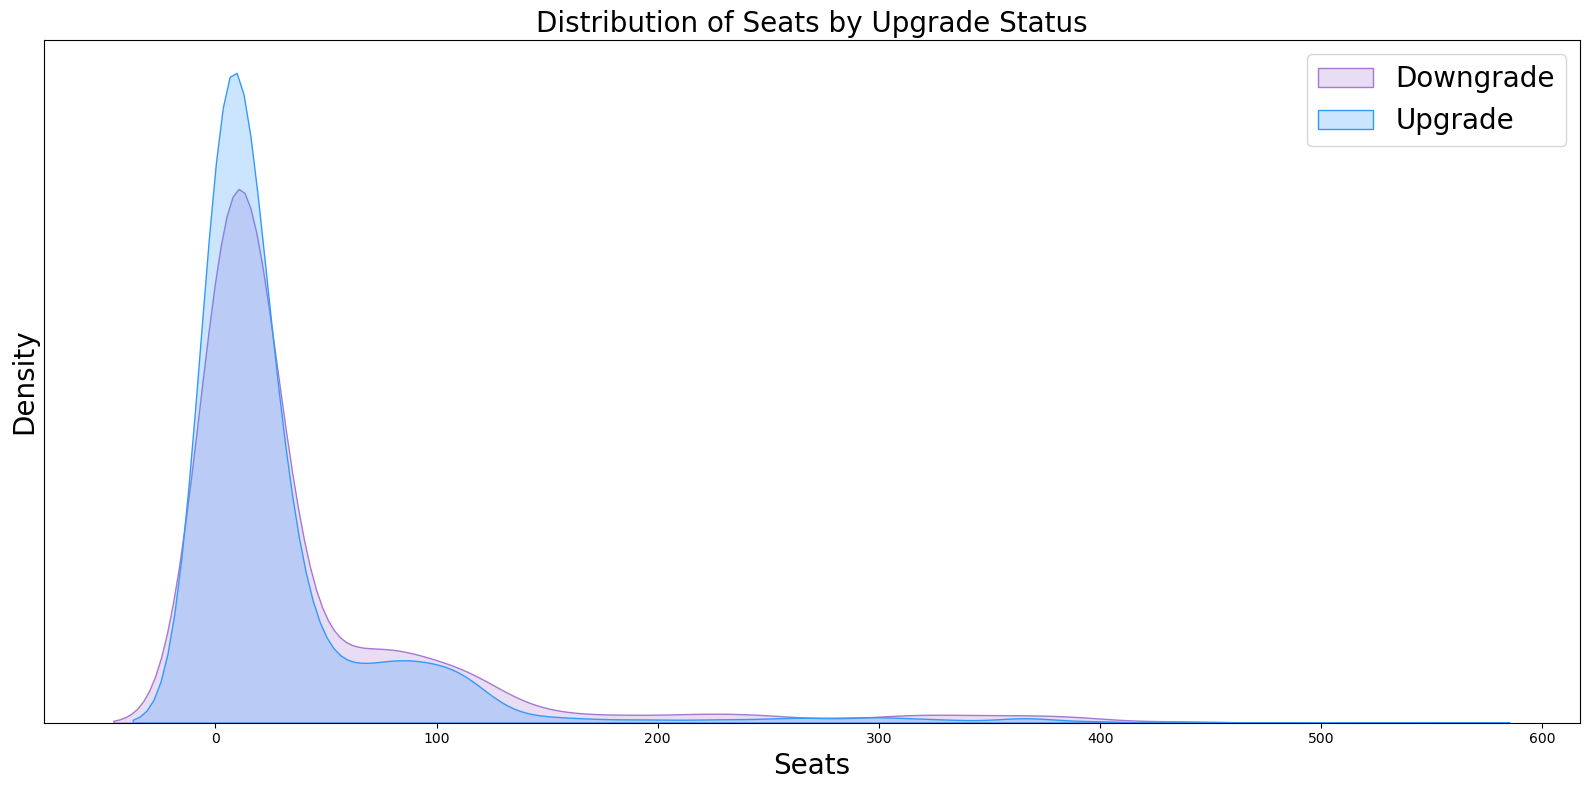

In [101]:
plt.figure(figsize=(16, 8))
sns.kdeplot(data=df[df['upgrade'] == 0]['seats'], label='Downgrade', fill=True, color="#a678d1")
sns.kdeplot(data=df[df['upgrade'] == 1]['seats'], label='Upgrade', fill=True, color="#3399ff")
plt.title('Distribution of Seats by Upgrade Status', fontsize = 20)
plt.xlabel('Seats', fontsize = 20)
plt.ylabel('Density', fontsize = 20)
plt.yticks([])
plt.legend(fontsize = 20)
plt.tight_layout()
plt.savefig("seats_distribution_by_upgrade.png", dpi=300)
plt.show()

/var/folders/st/vt6hxj_93517y4vp9mxflvn80000gn/T/ipykernel_39183/3827292687.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = tmp.groupby(binned)['upgrade'].agg(rate='mean', n='size').reset_index()


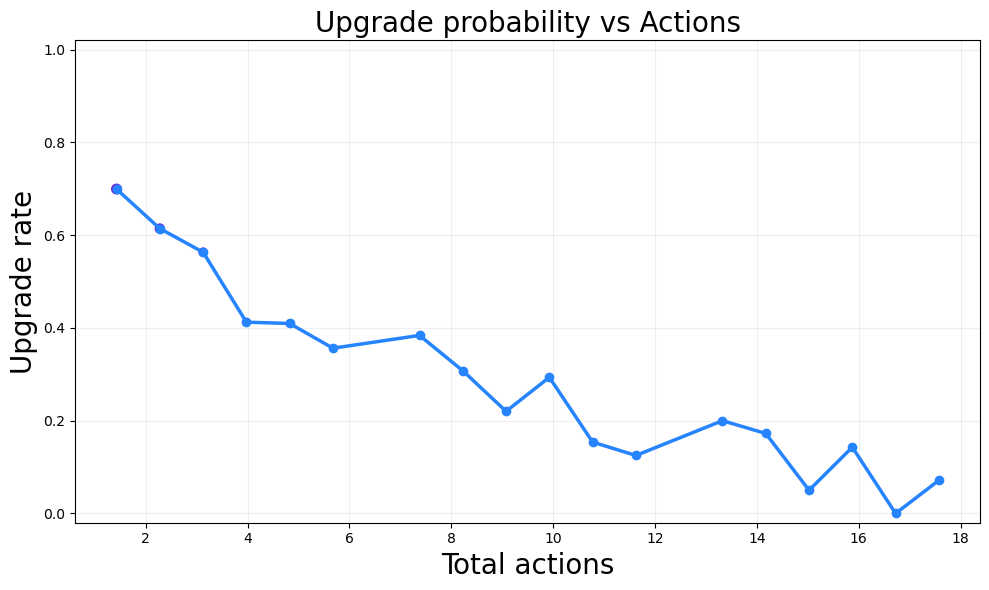

In [141]:
# Use your df with 'total' and 'upgrade'
actions = 'total'

# Clip extreme values (optional)
cap = df[actions].quantile(0.99)
tmp = df.copy()
tmp[actions] = tmp[actions].clip(upper=cap)

# Bin into equal-width intervals
nbins = 20
bins = np.linspace(tmp[actions].min(), tmp[actions].max(), nbins + 1)
binned = pd.cut(tmp[actions], bins, include_lowest=True)

# Group by bins, compute upgrade rate and bin count
g = tmp.groupby(binned)['upgrade'].agg(rate='mean', n='size').reset_index()

# Drop any rows with NaN rates (due to empty bins)
g = g.dropna()

# Compute bin centers for plotting
centers = g[binned.name].apply(lambda iv: (iv.left + iv.right)/2)

# Plot
plt.figure(figsize=(10, 6))
sizes = 40 * (g['n'] / g['n'].max() + 0.2)
plt.plot(centers, g['rate'], marker='o', linewidth=2.5, color="#2684FF")
plt.scatter(centers, g['rate'], s=sizes, color="#6C2BD9")  # purple dots
plt.ylim(-0.02, 1.02)
plt.xlabel('Total actions', fontsize = 20)
plt.ylabel('Upgrade rate', fontsize = 20)
plt.title('Upgrade probability vs Actions', fontsize = 20)
plt.grid(alpha=0.2)
plt.tight_layout()
plt.savefig("upgrade_vs_actions_binned_fixed.png", dpi=300)
plt.show()

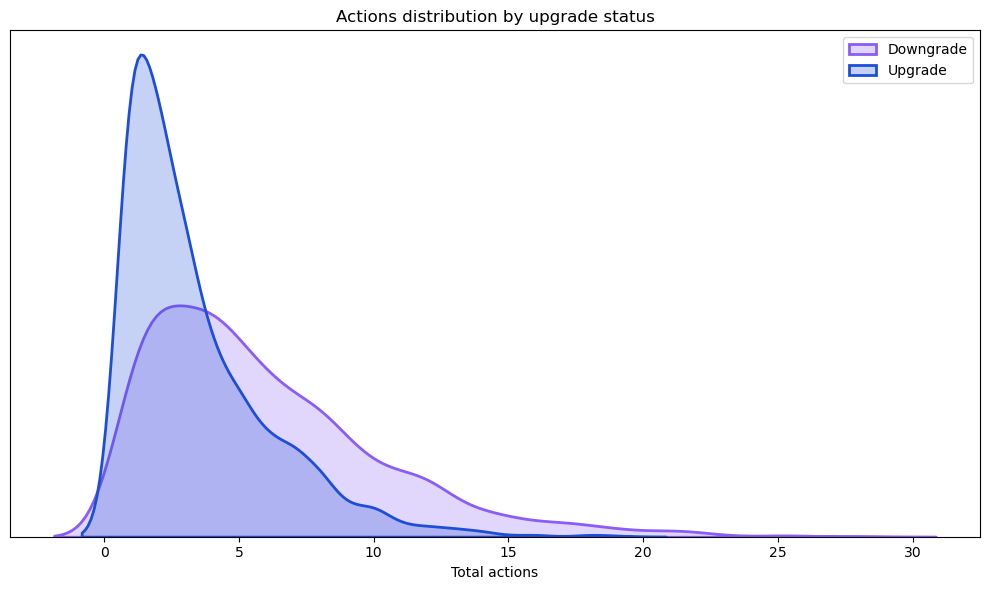

In [137]:
plt.figure(figsize=(10,6))
sns.kdeplot(data=df[df['upgrade']==0][actions], fill=True, linewidth=2, color="#8B5CF6", label='Downgrade')
sns.kdeplot(data=df[df['upgrade']==1][actions], fill=True, linewidth=2, color="#1D4ED8", label='Upgrade')
plt.title('Actions distribution by upgrade status')
plt.xlabel('Total actions')
plt.ylabel('')
plt.yticks([])
plt.legend()
plt.tight_layout()
plt.savefig("actions_distribution_by_upgrade.png", dpi=300)
plt.show()

/var/folders/st/vt6hxj_93517y4vp9mxflvn80000gn/T/ipykernel_39183/3551746306.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = tmp.groupby(binned)['upgrade'].agg(rate='mean', n='size').reset_index()


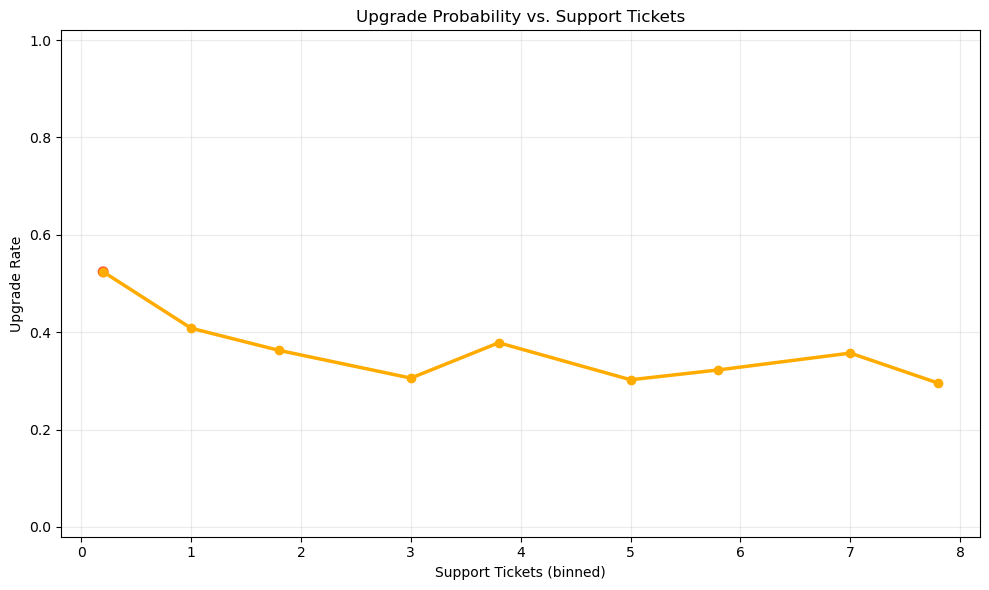

In [143]:
tmp = df.copy()

# Cap extreme values (optional, helps with outliers)
cap = tmp['support_tickets'].quantile(0.99)
tmp['support_tickets'] = tmp['support_tickets'].clip(upper=cap)

# Bin into equal-width intervals
nbins = 20
bins = np.linspace(tmp['support_tickets'].min(), tmp['support_tickets'].max(), nbins + 1)
binned = pd.cut(tmp['support_tickets'], bins, include_lowest=True)

# Group by bins, compute upgrade rate and count
g = tmp.groupby(binned)['upgrade'].agg(rate='mean', n='size').reset_index()

# Drop bins with no data (NaN rates)
g = g.dropna()

# Compute bin centers for plotting
centers = g[binned.name].apply(lambda iv: (iv.left + iv.right) / 2)

# Plot
plt.figure(figsize=(10, 6))
sizes = 40 * (g['n'] / g['n'].max() + 0.2)
plt.plot(centers, g['rate'], marker='o', linewidth=2.5, color="#FFAB00")
plt.scatter(centers, g['rate'], s=sizes, color="#FF5630")  # reddish-orange dots
plt.ylim(-0.02, 1.02)
plt.xlabel('Support Tickets (binned)')
plt.ylabel('Upgrade Rate')
plt.title('Upgrade Probability vs. Support Tickets')
plt.grid(alpha=0.25)
plt.tight_layout()
plt.savefig("upgrade_vs_support_tickets.png", dpi=300)
plt.show()

/var/folders/st/vt6hxj_93517y4vp9mxflvn80000gn/T/ipykernel_39183/4216906422.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('bin')['upgrade']


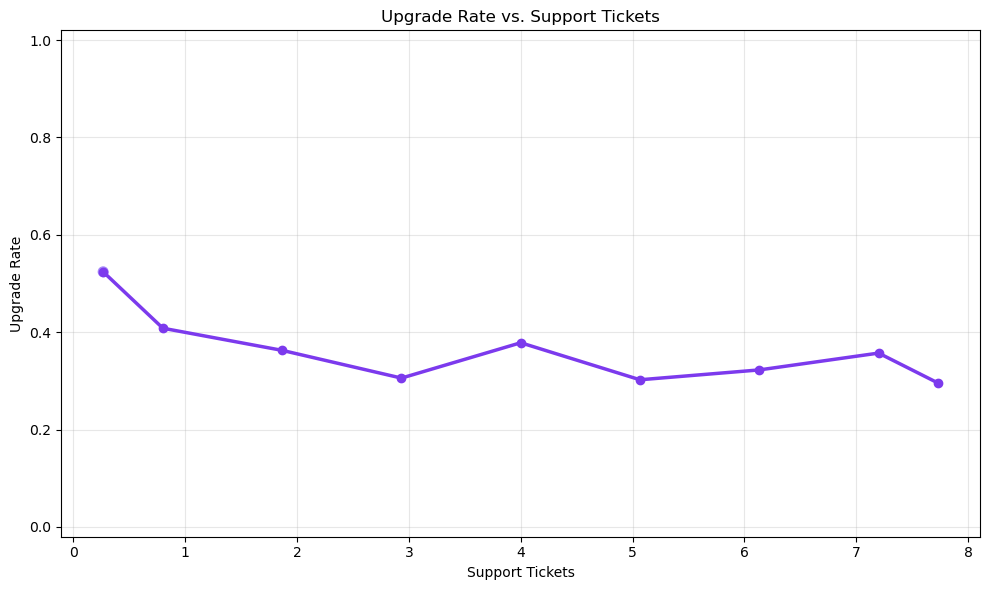

In [153]:
tmp = df.copy()
tmp['support_tickets'] = tmp['support_tickets'].clip(upper=tmp['support_tickets'].quantile(0.99))

nbins = 15
bins = np.linspace(tmp['support_tickets'].min(), tmp['support_tickets'].max(), nbins+1)
g = (tmp.assign(bin=pd.cut(tmp['support_tickets'], bins, include_lowest=True))
       .groupby('bin')['upgrade']
       .agg(rate='mean', n='size')
       .reset_index()
       .dropna())
centers = g['bin'].apply(lambda iv: (iv.left + iv.right)/2)

plt.figure(figsize=(10,6))
plt.plot(centers, g['rate'], marker='o', linewidth=2.5, color="#7c3aed")
plt.scatter(centers, g['rate'], s=40 * (g['n']/g['n'].max() + 0.2), color="#a78bfa")
plt.ylim(-0.02, 1.02)
plt.xlabel('Support Tickets'); plt.ylabel('Upgrade Rate')
plt.title('Upgrade Rate vs. Support Tickets')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('upgrade_vs_support_tickets.png', dpi=300)
plt.show()

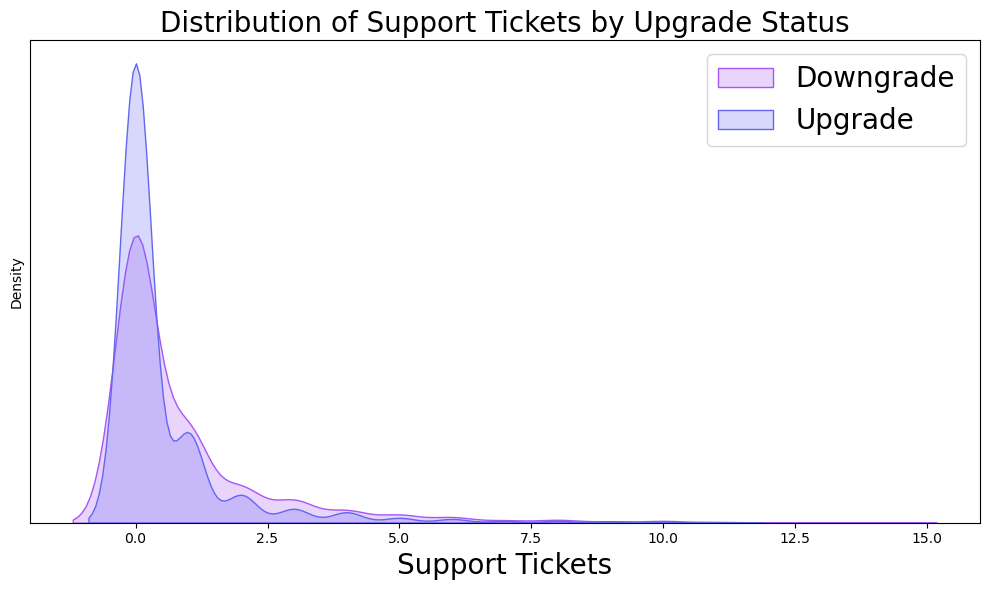

In [151]:
plt.figure(figsize=(10,6))
sns.kdeplot(data=df[df['upgrade'] == 0]['support_tickets'], label='Downgrade', fill=True, color="#a855f7")
sns.kdeplot(data=df[df['upgrade'] == 1]['support_tickets'], label='Upgrade', fill=True, color="#6366f1")
plt.xlabel("Support Tickets", fontsize = 20)
plt.title("Distribution of Support Tickets by Upgrade Status", fontsize = 20)
plt.yticks([])  # optional: remove y axis
plt.legend(fontsize = 20)
plt.tight_layout()
plt.savefig("support_tickets_distribution.png", dpi=300)
plt.show()

/var/folders/st/vt6hxj_93517y4vp9mxflvn80000gn/T/ipykernel_39183/188122106.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='upgrade', y='support_tickets', palette=["#d8b4fe", "#818cf8"])


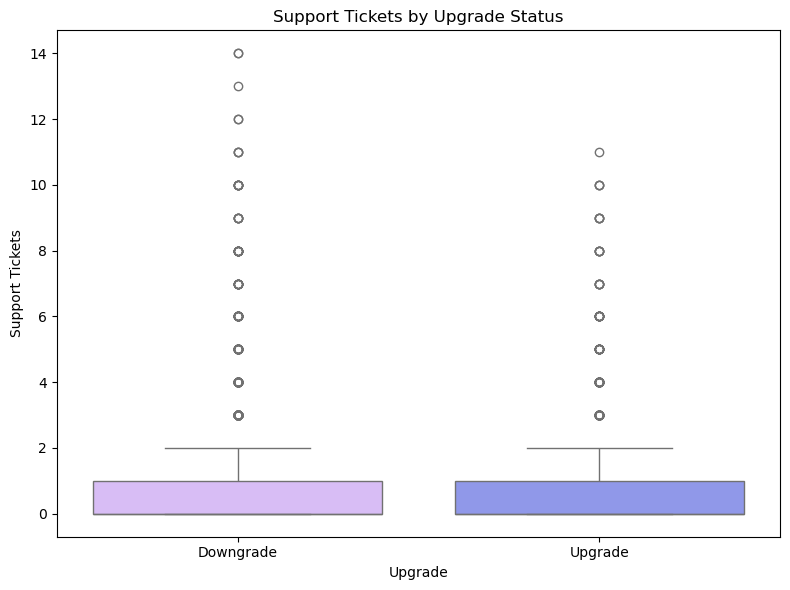

In [149]:
plt.figure(figsize=(8,6))
sns.boxplot(data=df, x='upgrade', y='support_tickets', palette=["#d8b4fe", "#818cf8"])
plt.xticks([0,1], ['Downgrade','Upgrade'])
plt.title('Support Tickets by Upgrade Status')
plt.xlabel('Upgrade')
plt.ylabel('Support Tickets')
plt.tight_layout()
plt.savefig("support_tickets_boxplot.png", dpi=300)
plt.show()